# Rezago Habitacional - México

In [104]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [105]:
br_path = ('C:/CIG/III Cuatrimestre/Geoinformática/Tarea 3/archivos/municipios_rez.gpkg')

In [106]:
br = gpd.read_file(br_path).set_index('clave')

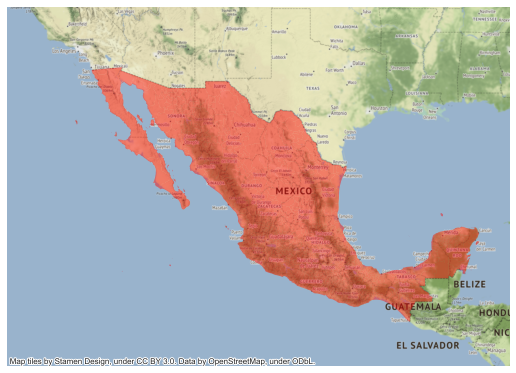

In [159]:
ax = br.to_crs(epsg=3857).plot(figsize=(9, 9), alpha=0.45, color='red',  edgecolor='none')
ax.set_axis_off();
ctx.add_basemap(ax);

In [108]:
br.head()

,CVE_ENT,CVE_MUN,NOM_MUN,nuevo_inde,base_rh,base_delitos,base_im,base_indigenas,base_rh_index,geometry
clave,,,,,,,,,,
01005,01,005,Jesús María,-2.00,0.075,2522,-1.256,0.000,0.136,(POLYGON ((-102.3356775711372 22.0506652149647...
01011,01,011,San Francisco de los Romo,-2.18,0.059,3000,-1.156,0.000,0.144,(POLYGON ((-102.1527236904711 22.0896216518431...
01001,01,001,Aguascalientes,-2.45,0.045,3344,-1.676,0.119,0.144,(POLYGON ((-102.1064122399267 22.0603544130312...
01008,01,008,San José de Gracia,-1.54,0.195,2236,-0.735,0.000,0.202,(POLYGON ((-102.4561096056242 22.3232322386917...
01007,01,007,Rincón de Romos,-1.68,0.130,2118,-1.045,0.000,0.158,(POLYGON ((-102.226841597708 22.37392855834552...


In [109]:
br.columns

Index(['CVE_ENT', 'CVE_MUN', 'NOM_MUN', 'nuevo_inde', 'base_rh',
       'base_delitos', 'base_im', 'base_indigenas', 'base_rh_index',
       'geometry'],
      dtype='object')

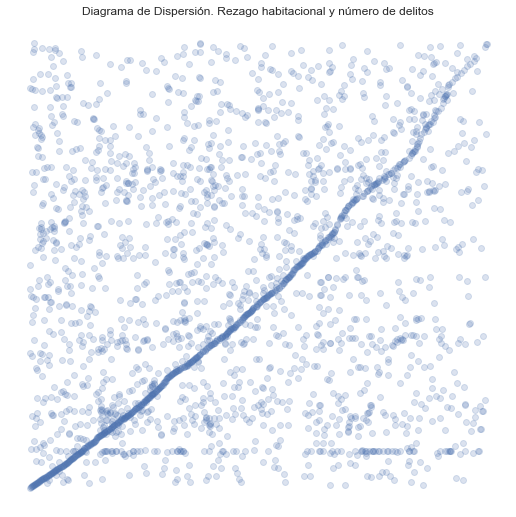

In [156]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(br['base_rh'], br['base_delitos'], alpha=0.2)
ax.set_axis_off()
plt.title('Diagrama de Dispersión. Rezago habitacional y número de delitos');

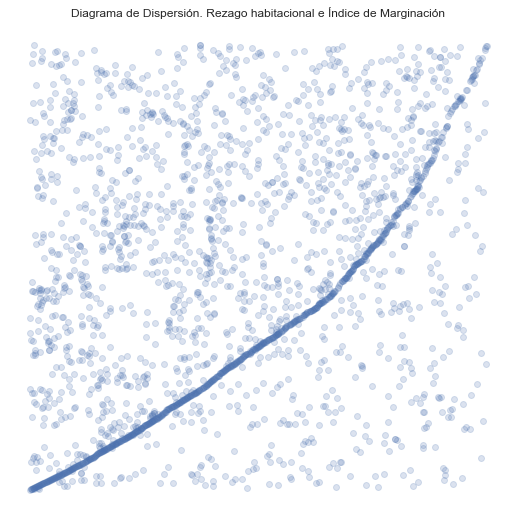

In [111]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(br['base_rh'], br['base_im'], alpha=0.2)
ax.set_axis_off()
plt.title('Diagrama de Dispersión. Rezago habitacional e Índice de Marginación');

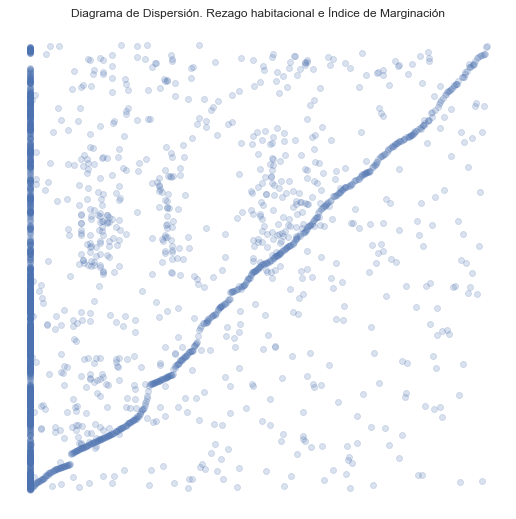

In [112]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(br['base_indigenas'], br['base_im'], alpha=0.2)
ax.set_axis_off()
plt.title('Diagrama de Dispersión. Rezago habitacional e Índice de Marginación');

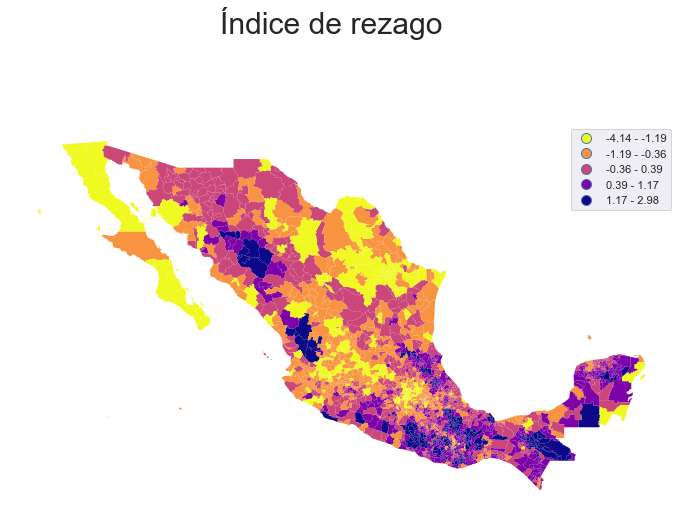

In [160]:
f, ax = plt.subplots(1, figsize=(12, 9))
br.plot(column='nuevo_inde', scheme='Fisher_Jenks', legend=True, cmap='plasma_r', ax=ax, edgecolor = 'none')
f.suptitle('Índice de rezago', size=30)
ax.set_axis_off()
plt.show();

## Matriz de Pesos

Constuiremos una metriz de pesos por contiguidad de reina.

In [114]:
%time w = ps.weights.Queen.from_dataframe(br)

Wall time: 39.7 s


In [115]:
w['01005'] 

{'01001': 1.0, '01011': 1.0, '01003': 1.0, '01008': 1.0, '01006': 1.0}

Estandarizando los renglones de la matriz

In [85]:
w.transform = 'R'


Vemos ahora que los pesos para cada renglón suman a 1

In [87]:
w['01005']

{'01001': 0.2, '01011': 0.2, '01003': 0.2, '01008': 0.2, '01006': 0.2}

## Retardo Espacial

In [118]:
br['nuevo_inde'] = br['nuevo_inde'].astype(float)

In [119]:
br['z_nuevo_inde'] = (br['nuevo_inde']- br['nuevo_inde'].mean())/br['nuevo_inde'].std()

In [121]:
br['lag_nuevo_inde'] = ps.lag_spatial(w, br['z_nuevo_inde'])

## Autocorrelación espacial globlal

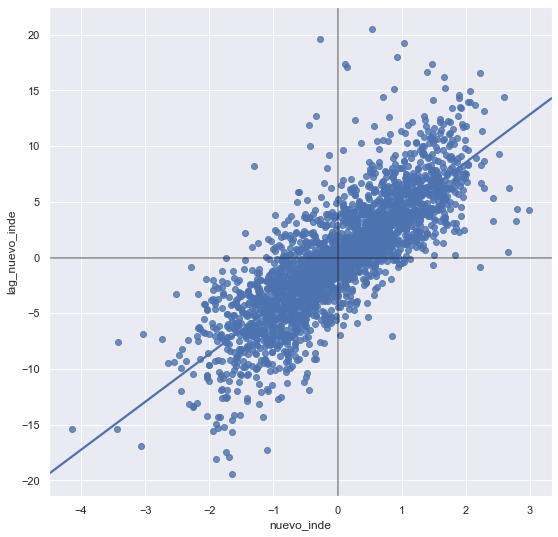

In [122]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos 
sns.regplot(x='nuevo_inde', y='lag_nuevo_inde', data=br, ci=None)
# Agergamos líneas horizontal y vertical
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Despliegue
plt.show();

## I de Moran

In [123]:
mi = ps.Moran(br['nuevo_inde'], w)

In [124]:
#Desplegamos el valor de la I de Moran
mi.I

0.7431373189552214

In [126]:
# Obtenemos la pseudo significancia del patrón observado
mi.p_sim

0.001

## Autocorrelación Espacial Local

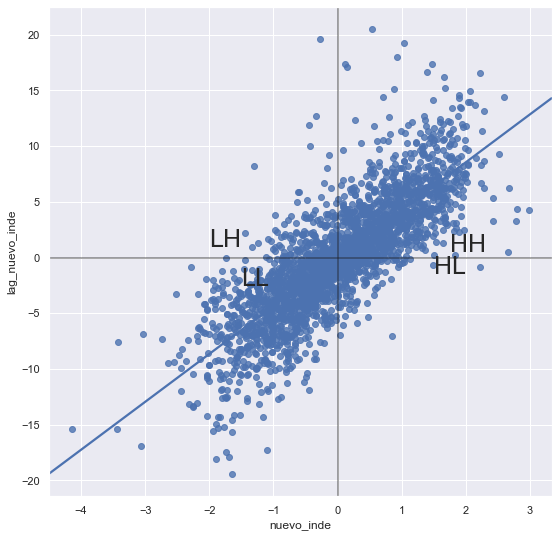

In [128]:
# Ajustamos la figura y los ejes
f, ax = plt.subplots(1, figsize=(9, 9))
# Graficamos los valores
sns.regplot(x='nuevo_inde', y='lag_nuevo_inde', data=br, ci=None)
# Agregamos líneas verticales, horizontales y etiquetas
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)
# Desplegamos la gráfica
plt.show();

In [130]:
lisa = ps.Moran_Local(br['nuevo_inde'], w)

In [131]:
# Separa a las observaciones en significativas o no
br['significant'] = lisa.p_sim < 0.05
# Almacenamos el cuadrante al que pertenecen las observaciones
br['quadrant'] = lisa.q

In [132]:
br['significant'].head()

clave
01005    True
01011    True
01001    True
01008    True
01007    True
Name: significant, dtype: bool

In [133]:
lisa.p_sim[:5]

array([0.001, 0.001, 0.001, 0.001, 0.001])

In [134]:
br['quadrant'].head()

clave
01005    3
01011    3
01001    3
01008    3
01007    3
Name: quadrant, dtype: int32

## Mapa de clústers

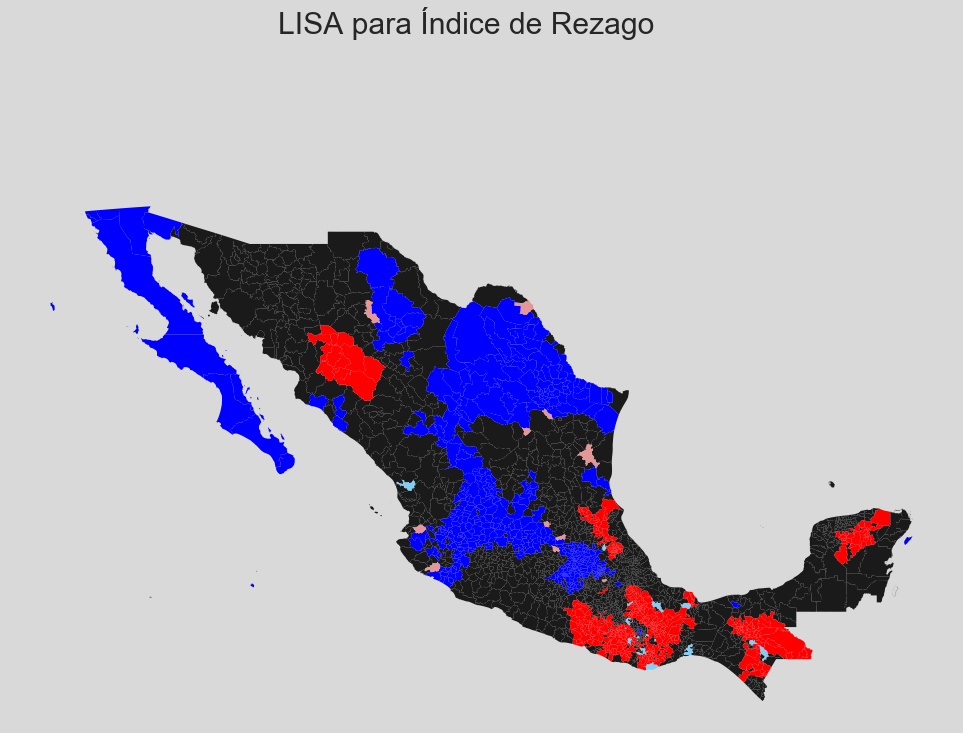

In [161]:
# Ajusta la figura y los ejes
f, ax = plt.subplots(1, figsize=(17, 13))
# Grafica observaciones no significativas
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k', edgecolor = 'none')
# Grafica clusters Alto-Alto
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red', edgecolor = 'none')
# Grafica clusters Bajo-Bajo
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue', edgecolor = 'none')
# Grafica anomalías espacials Bajo-ALto
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4', edgecolor = 'none')
# Grafica anomalías espaciales Alto-Bajo
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696', edgecolor = 'none')
# Estilo y despliegue
f.suptitle('LISA para Índice de Rezago', size=30)
f.set_facecolor('0.85')
ax.set_axis_off()
plt.show();